# Procesamiento Básico de Señal Digital para Relés

Trabajo presentado por: 
- Andrés Enrique Avila Rojas
- Carlos Salomón Saenz Díaz
- Alberto Bérmudes Arias
- Valentina Reyes Martínez

In [3]:
# Modulos necesarios
import numpy as np
from scipy import signal, fftpack
from matplotlib import pyplot as plt
from scipy.io import loadmat
import cmath 

## Definición de métodos a Utilizar

A continuación se definen las funciones para el cálculo completo de las etapas del procesamiento digital de la señal para un relé.

### Etapa de submuestreo

Se muestrea a la frecuencia de muestro del relé estipulada por el usuario

In [7]:
def subsampling(time,data,fs,fk,fs_user_cycle):
    # time is the vector of time
    # data is the vector with the signal
    # fs_comtrade is the sample rate from the comtrade file
    # fk is the frequency of the system
    # fs_user_cycle is the sample rate given by user
    N1 = fs_user_cycle
    fs_cycle = fs/fk
    N=np.int(fs_cycle)
    N_tot = np.int(len(data)/fs_cycle)
    new_data = [0]
    new_time = [0]
    for i in np.arange(N_tot):
        xi=data[i*N:i*N+N]
        ti=time[i*N:i*N+N]
        new_data[i*N1:i*N1+N1] = signal.resample(xi, N1)
        new_time[i*N1:i*N1+N1] = np.linspace(ti[0], ti[-1], N1, endpoint=False)
        
    return (new_time,new_data)

### Modulo de S&H y A/D (Quantizer)

Método para digitalizar la señal de entrada

In [62]:
def quantizer(data, quantizing_bits):
    # data is the vector with the signal
    # quantizing_bits is the number of bits for the converter
    # Quantizer - S&H and ADC
    quantizing_levels   = 2 ** quantizing_bits
    quantizing_step     = (np.max(data)-np.min(data)) / quantizing_levels
    quantizing_signal   = np.round (data / quantizing_step) * quantizing_step;
    
    return quantizing_signal

### Transformada de Fourier (Filtro de componentes ortogonales basado en filtro coseno)

Se presenta la transformada directa de Fourier con el ventaneo de la señal, teniendo la siguiente representación en componentes ortogonales.

$$X_c = \frac{2}{N}\sum_{k=0}^{N-1} x_k \cos \left(\frac{2\pi}{N} k \right)$$

$$X_s = \frac{2}{N}\sum_{k=0}^{N-1} x_k \sin \left(\frac{2\pi}{N} k \right)$$

In [4]:
def DFT(time, data, fk, fs_user_cycle):
    # time is the vector of time
    # data is the vector with the signal
    # fk is the frequency of the system
    # fs_user_cycle is the sample rate given by user
    
    N=np.int(fs_user_cycle)
    N_tot = len(data)-N
    Xc = [0]*N_tot
    Xs = [0]*N_tot
    t = [0]*N_tot
    
    # Ciclo para el ventaneo
    for i in np.arange(N_tot):
        xi=data[i:i+N]
        t[i]=time[i]
        Xc_sum = 0
        Xs_sum = 0
        # Ciclo para el filtro coseno
        for k in np.arange(N):
            Xc_temp=xi[k]*np.cos(2*np.pi*k/(N))
            Xc_sum=Xc_sum+Xc_temp
            Xs_temp=xi[k]*np.sin(2*np.pi*k/(N))
            Xs_sum=Xs_sum+Xs_temp
            
        Xc[i]= 2/(N*np.sqrt(2))*Xc_sum
        Xs[i]= 2/(N*np.sqrt(2))* Xs_sum
        
    return t, Xc, Xs

## Obtención de Salidas del Programa (Gráficas y lectura de datos)

### Se obtienen y grafican los datos del archivo .mat

Se debe hacer una conversión de la versión obtenida de ATP a una versión -v7 (Ver Change_version.m)

Record has 300001 samples
Sampling rate is 1000000 samples/sec.


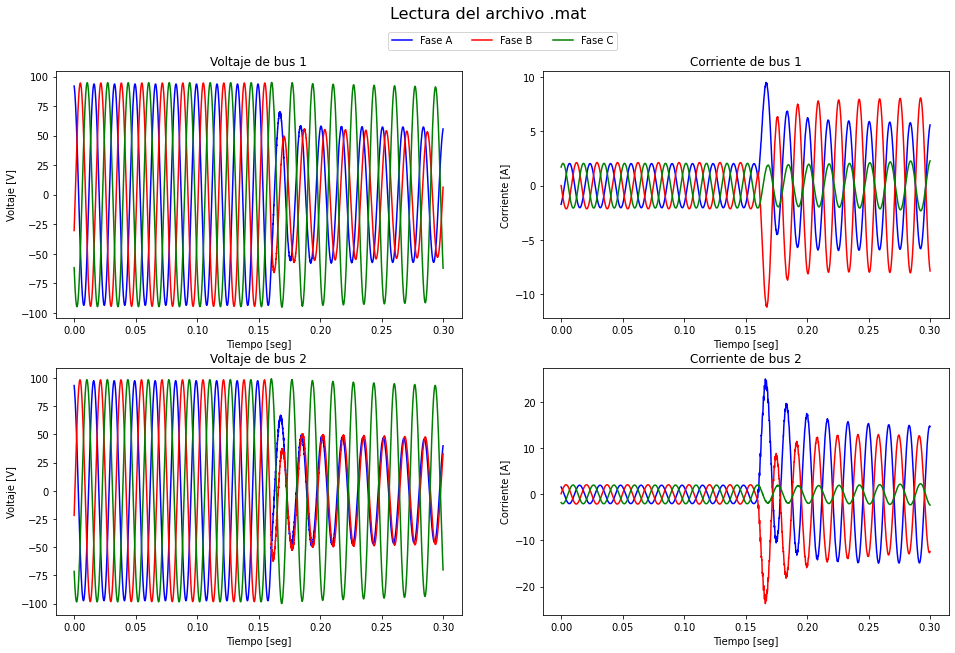

In [4]:
mat = loadmat('Falla_AB_90%_001ohm.mat') # El archivo se selecciona desde la interfaz

# Reading time vector:
time = mat['t'] #Se conoce que todos los archivos vendrán con este vector incluido

N = len(time)
fs = np.int(np.ceil(len(time)/time[-1])-4)

print('Record has {} samples'.format(N))
print('Sampling rate is {} samples/sec.'.format(fs))


# Line frequency in Hz
fk = 60 # It can be set automatically


# Reading voltaje and currents
voltages_bus1 = np.empty(([len(time),3]))
currents_bus1 = np.empty(([len(time),3]))

voltages_bus2 = np.empty(([len(time),3]))
currents_bus2 = np.empty(([len(time),3]))

# Primary side
#Trafo_p =
#Trafo_s =
ratio_V = 1

col=0
for i in ['a','b','c']:
    voltages_bus1[:,col] = mat['vVt1'+i].ravel()
    currents_bus1[:,col] = mat['iCt1'+i].ravel()
    voltages_bus2[:,col] = mat['vVt2'+i].ravel()
    currents_bus2[:,col] = mat['iCt2'+i].ravel()
    col=col+1
    
measures = [voltages_bus1,currents_bus1,voltages_bus2,currents_bus2]
#print(N_tot)
            
f, axarr = plt.subplots(2, 2, figsize =(16, 10))
f.suptitle('Lectura del archivo .mat', y=0.97, fontsize=16)
labels = ['Fase A', 'Fase B', 'Fase C']

n_bus=1
for i in range(len(measures)):
    if (i % 2)==0: #Si es par
        p1 = np.int(i/2)
        p2 = 0
        axarr[p1,p2].set_title(('Voltaje de bus '+str(n_bus)))
        axarr[p1,p2].set_ylabel('Voltaje [V]')
    else:
        p1 = np.int(np.ceil(i/2)-1)
        p2 = 1
        axarr[p1,p2].set_title(('Corriente de bus '+str(n_bus)))
        axarr[p1,p2].set_ylabel('Corriente [A]')
        n_bus=n_bus+1
        
    axarr[p1,p2].set_xlabel('Tiempo [seg]')
    axarr[p1,p2].plot(time, measures[i][:,0], 'b-', label='Fase A')
    axarr[p1,p2].plot(time, measures[i][:,1], 'r-', label='Fase B')
    axarr[p1,p2].plot(time, measures[i][:,2], 'g-', label='Fase C')

f.legend(axarr[1,1].get_lines(), labels, ncol=3, bbox_to_anchor=(0.54, 0.87))

Ejemplo con Falla Bifásica entre B y C.

### Etapa de Submuestreo de las Señales

En este caso, se submuestrea a 16 muestras/ciclo, típicamente es valor se toma teniendo en cuenta lo definido por el usuario en la interfaz.

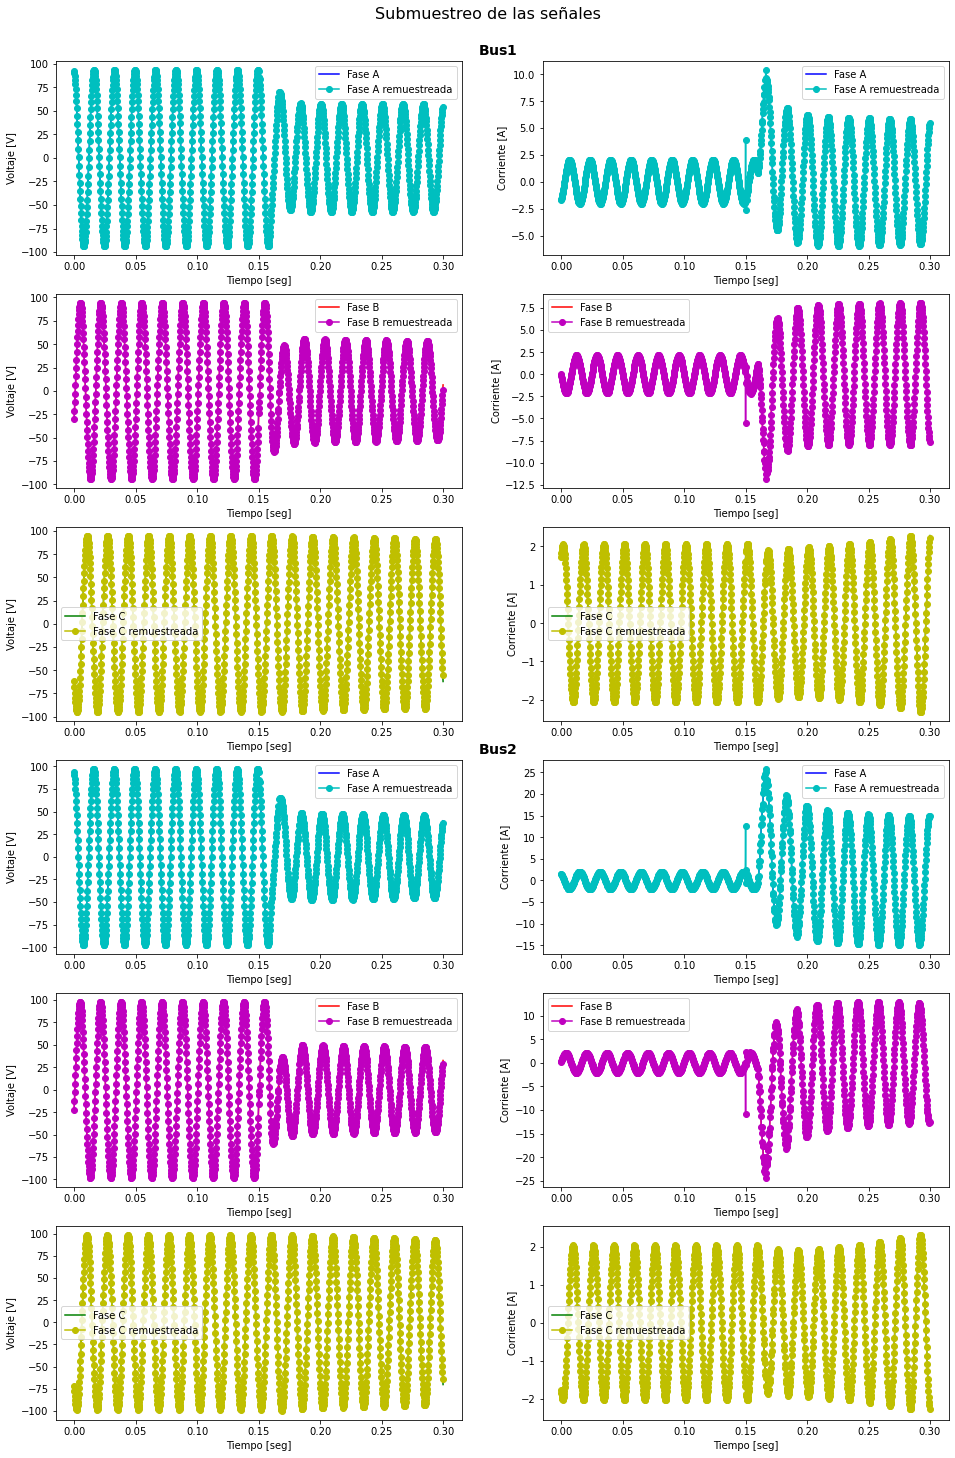

In [68]:
# Subsampling voltaje and currents
fs_user_cycle = 64 # ESTA DATO VIENE DE LA INTERFAZ
N_tot = np.int(N*fk/fs)*fs_user_cycle
V_bus1_sub = np.empty(([N_tot,3]))
I_bus1_sub = np.empty(([N_tot,3]))
V_bus2_sub = np.empty(([N_tot,3]))
I_bus2_sub = np.empty(([N_tot,3]))
time_sub = np.empty(([N_tot,6]))
for i in np.arange(6):
    if i<3:
        time_sub[:,i], V_bus1_sub[:,i] = subsampling(time,voltages_bus1[:,i],fs,fk,fs_user_cycle)
        time_sub[:,i], V_bus2_sub[:,i] = subsampling(time,voltages_bus2[:,i],fs,fk,fs_user_cycle)
    else:
        time_sub[:,i], I_bus1_sub[:,i-3] = subsampling(time,currents_bus1[:,i-3],fs,fk,fs_user_cycle)
        time_sub[:,i], I_bus2_sub[:,i-3] = subsampling(time,currents_bus2[:,i-3],fs,fk,fs_user_cycle)

measures_sub = [V_bus1_sub,I_bus1_sub,V_bus2_sub,I_bus2_sub]
# PLOTING -----------------------------------------------------------------
f, axarr = plt.subplots(6, 2, figsize =(16, 25))
f.suptitle('Submuestreo de las señales', y=0.91, fontsize=16)
# Se definen los colores para cada fase
colors = ['b-','r-','g-'] 
colors_sub = ['co-','mo-','yo-']
# Se definen los labels para cada fase
labels_sub = ['Fase A remuestreada', 'Fase B remuestreada','Fase C remuestreada']
cont = 0
for i in range(len(measures_sub)):
    axarr.flat[0].set_title(r'$\bf{Bus 1}$',x=1.09, fontsize=14)
    axarr[3,0].set_title(r'$\bf{Bus 2}$',x=1.09, fontsize=14)
    for j in np.arange(3):
        if (cont % 2)==0: #Si es par
            p1 = np.int(cont/2)
            p2 = 0
            axarr[p1,p2].set_ylabel('Voltaje [V]')
        else:
            p1 = np.int(np.ceil(cont/2)-1)
            p2 = 1
            axarr[p1,p2].set_ylabel('Corriente [A]')
        if (i<2):
            p1 = j
            if (i%2)==0: p2=0
            else: p2=1
        else:
            p1 = j + 3
            if (i%2)==0: p2=0
            else: p2=1
        axarr[p1,p2].set_xlabel('Tiempo [seg]')
        axarr[p1,p2].plot(time, measures[i][:,j], colors[j], label=labels[j])
        axarr[p1,p2].plot(time_sub[:,i], measures_sub[i][:,j], colors_sub[j], label=labels_sub[j])
        axarr[p1,p2].legend()
        cont = cont + 1


### Etapa de Conversión A/D

1152


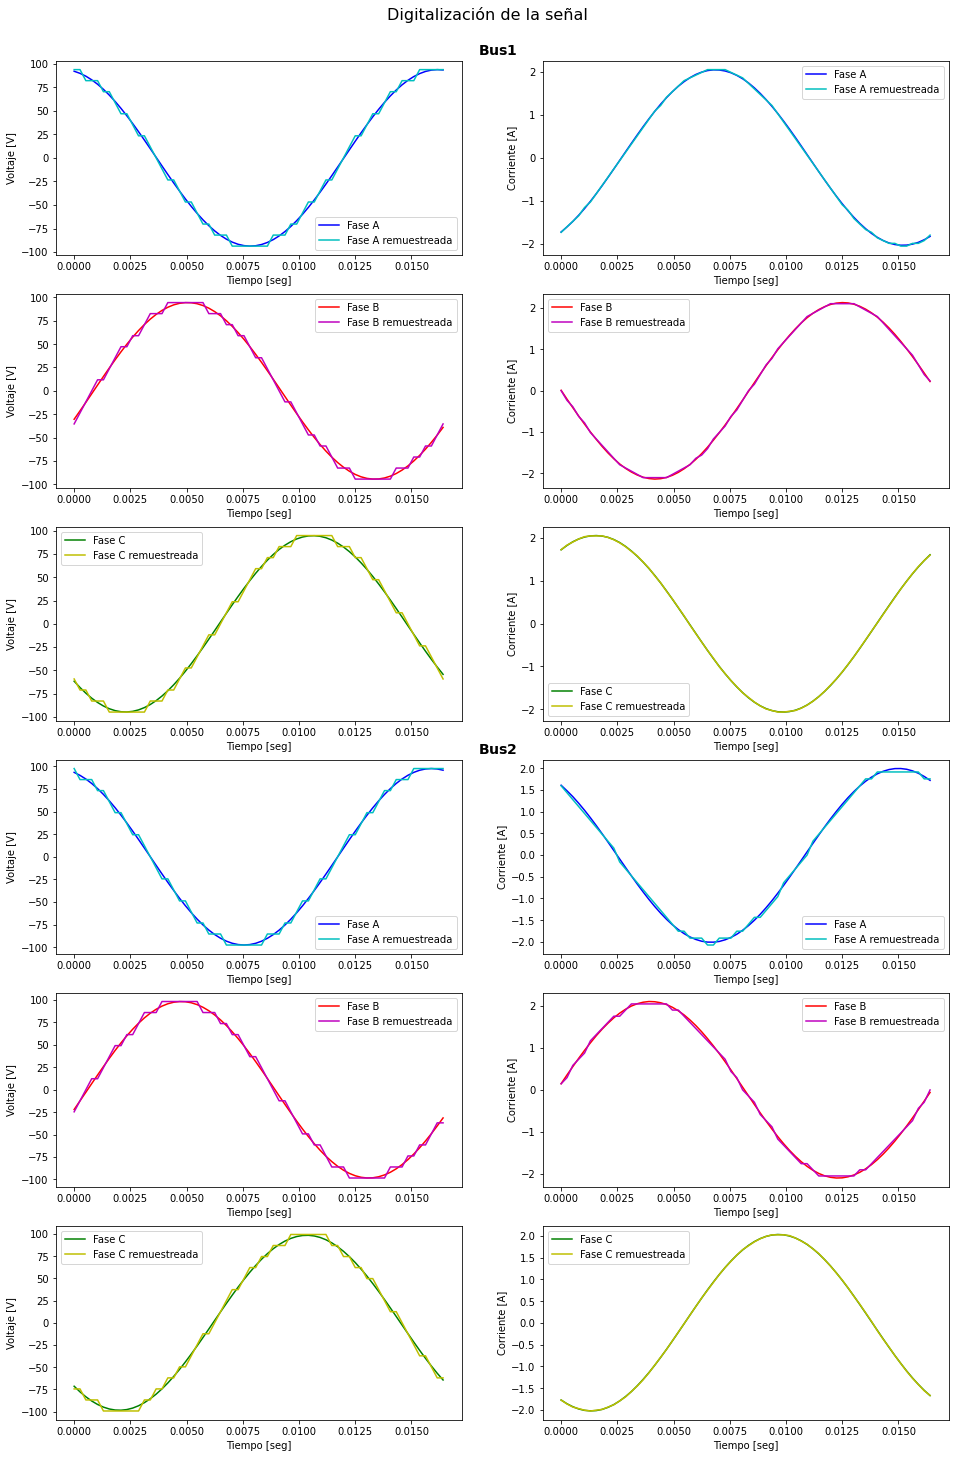

In [73]:
quantizing_bits_V = 4 # Valor típico: 12 (Voltaje)
quantizing_bits_I = 8 # Valor típico: 16 (Corriente)
dig_V_bus1_sub = np.empty(([N_tot,3]))
dig_I_bus1_sub = np.empty(([N_tot,3]))
dig_V_bus2_sub = np.empty(([N_tot,3]))
dig_I_bus2_sub = np.empty(([N_tot,3]))
for i in np.arange(6):
    if i<3:
        dig_V_bus1_sub[:,i] = quantizer(V_bus1_sub[:,i], quantizing_bits_V)
        dig_V_bus2_sub[:,i] = quantizer(V_bus2_sub[:,i], quantizing_bits_V)
    else:
        dig_I_bus1_sub[:,i-3] = quantizer(I_bus1_sub[:,i-3], quantizing_bits_I)
        dig_I_bus2_sub[:,i-3] = quantizer(I_bus2_sub[:,i-3], quantizing_bits_I)
print(N_tot)

measures_sub_dig = [dig_V_bus1_sub,dig_I_bus1_sub,dig_V_bus2_sub,dig_I_bus2_sub]
# PLOTING -----------------------------------------------------------------
f, axarr = plt.subplots(6, 2, figsize =(16, 25))
f.suptitle('Digitalización de la señal', y=0.91, fontsize=16)
colors_sub_dig =['c-','m-','y-']
cont = 0
for i in range(len(measures_sub_dig)):
    axarr.flat[0].set_title(r'$\bf{Bus 1}$',x=1.09, fontsize=14)
    axarr[3,0].set_title(r'$\bf{Bus 2}$',x=1.09, fontsize=14)
    for j in np.arange(3):
        if (cont % 2)==0: #Si es par
            p1 = np.int(cont/2)
            p2 = 0
            axarr[p1,p2].set_ylabel('Voltaje [V]')
        else:
            p1 = np.int(np.ceil(cont/2)-1)
            p2 = 1
            axarr[p1,p2].set_ylabel('Corriente [A]')
        if (i<2):
            p1 = j
            if (i%2)==0: p2=0
            else: p2=1
        else:
            p1 = j + 3
            if (i%2)==0: p2=0
            else: p2=1
        axarr[p1,p2].set_xlabel('Tiempo [seg]')
        axarr[p1,p2].plot(time_sub[:,i][0:fs_user_cycle], measures_sub[i][:,j][0:fs_user_cycle], colors[j], label=labels[j])
        axarr[p1,p2].plot(time_sub[:,i][0:fs_user_cycle], measures_sub_dig[i][:,j][0:fs_user_cycle], colors_sub_dig[j], label=labels_sub[j])
        axarr[p1,p2].legend()
        cont = cont + 1



### Etapa de Filtros Ortogonales

Inicalmente se muestran las gráficas de magnitud de las señales, mostrando el comportamiento a lo largo del tiempo del archivo COMTRADE leído previamente, y luego se muestra la variación en fase de estas mismas señales.

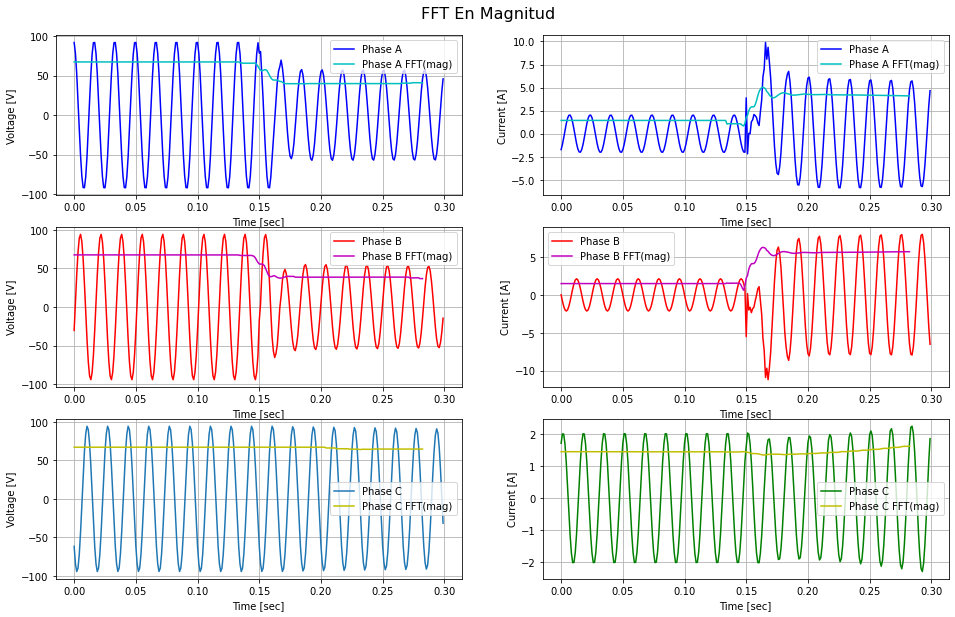

In [8]:
N_tot_DFT = N_tot-fs_user_cycle
Xc_V = np.empty(([N_tot_DFT,3]))
Xs_V = np.empty(([N_tot_DFT,3]))
Xc_C = np.empty(([N_tot_DFT,3]))
Xs_C = np.empty(([N_tot_DFT,3]))
X_V = np.empty(([N_tot_DFT,3]))
Y_V = np.empty(([N_tot_DFT,3]))
X_C = np.empty(([N_tot_DFT,3]))
Y_C = np.empty(([N_tot_DFT,3]))
t = np.empty(([N_tot_DFT,6]))
for i in np.arange(6):
    if i<3:
        t[:,i], Xc_V[:,i], Xs_V[:,i] = DFT(time_sub[:,i], dig_V_sub[:,i], fk, fs_user_cycle)
        X_V[:,i] = np.sqrt(np.power(Xc_V[:,i],2)+np.power(Xs_V[:,i],2))
        ajus = np.pi
        if Xc_V[-1,i]>0 and Xs_V[-1,i]<0:
            ajus = 2*np.pi
        elif Xc_V[-1,i]>0 and Xs_V[-1,i]>0:
            ajus = 0
        Y_V[:,i] = (np.arctan(Xs_V[:,i]/Xc_V[:,i])+ajus)*180/np.pi
    else:
        t[:,i], Xc_C[:,i-3], Xs_C[:,i-3] = DFT(time_sub[:,i], dig_C_sub[:,i-3], fk, fs_user_cycle)
        X_C[:,i-3] = np.sqrt(np.power(Xc_C[:,i-3],2)+np.power(Xs_C[:,i-3],2))
        if Xc_C[-1,i-3]>0 and Xs_C[-1,i-3]<0:
            ajus = 2*np.pi
        elif Xc_C[-1,i-3]>0 and Xs_C[-1,i-3]>0:
            ajus = 0
        Y_C[:,i-3] = (np.arctan(Xs_C[:,i-3]/Xc_C[:,i-3])+ajus)*180/np.pi

# PLOTING -----------------------------------------------------------------
f, axarr = plt.subplots(3, 2, figsize =(16, 10))
f.suptitle('FFT En Magnitud', y=0.92, fontsize=16)

# Plot Voltages
axarr[0,0].plot(time_sub[:,0], V_sub[:,0], 'b-', label='Phase A')
axarr[0,0].plot( t[:,0], X_V[:,0], 'c-', label='Phase A FFT(mag)')
axarr[1,0].plot(time_sub[:,1], V_sub[:,1], 'r-', label='Phase B')
axarr[1,0].plot( t[:,1], X_V[:,1], 'm-', label='Phase B FFT(mag)')
axarr[2,0].plot(time_sub[:,2], V_sub[:,2], label='Phase C')
axarr[2,0].plot( t[:,2], X_V[:,2], 'y-', label='Phase C FFT(mag)')

# Plot Currents
axarr[0,1].plot(time_sub[:,3], C_sub[:,0], 'b-', label='Phase A')
axarr[0,1].plot( t[:,3], X_C[:,0], 'c-', label='Phase A FFT(mag)')
axarr[1,1].plot(time_sub[:,4], C_sub[:,1], 'r-', label='Phase B')
axarr[1,1].plot( t[:,4], X_C[:,1], 'm-', label='Phase B FFT(mag)')
axarr[2,1].plot(time_sub[:,5], C_sub[:,2], 'g-', label='Phase C')
axarr[2,1].plot( t[:,5], X_C[:,2], 'y-', label='Phase C FFT(mag)')

for i in np.arange(3):
    axarr[i,0].set_xlabel('Time [sec]')
    axarr[i,0].set_ylabel('Voltage [V]')
    axarr[i,0].grid()
    axarr[i,0].legend()
    axarr[i,1].set_xlabel('Time [sec]')
    axarr[i,1].set_ylabel('Current [A]')
    axarr[i,1].grid()
    axarr[i,1].legend()

Grafica de Fases

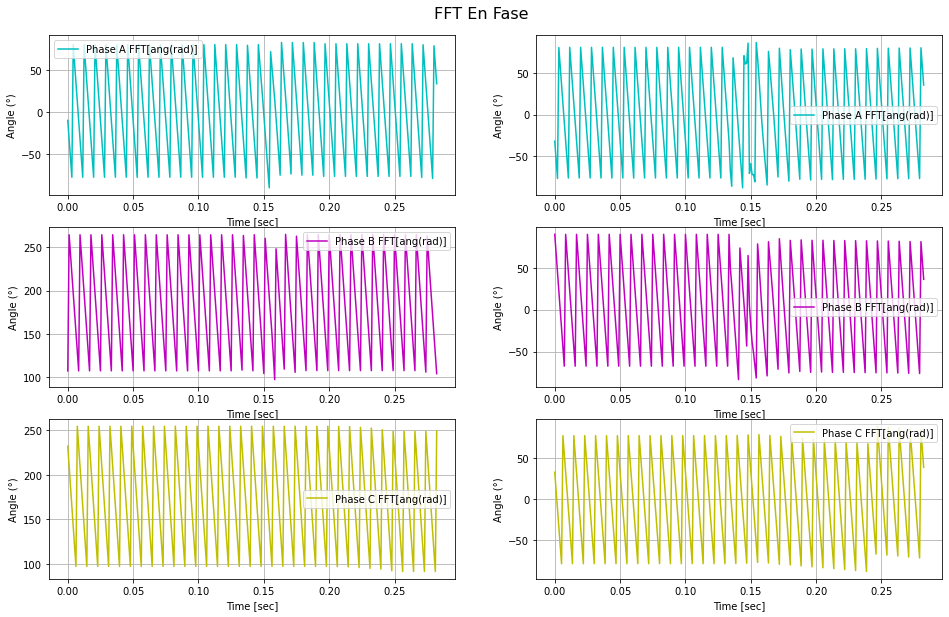

In [9]:
# PLOTING -----------------------------------------------------------------
f, axarr = plt.subplots(3, 2, figsize =(16, 10))
f.suptitle('FFT En Fase', y=0.92, fontsize=16)

# Plot Voltages
#axarr[0,0].plot(time_sub[:,0], V_sub[:,0], 'b-', label='Phase A')
axarr[0,0].plot( t[:,0], Y_V[:,0], 'c-', label='Phase A FFT[ang(rad)]')
#axarr[1,0].plot(time_sub[:,1], V_sub[:,1], 'r-', label='Phase B')
axarr[1,0].plot( t[:,1], Y_V[:,1], 'm-', label='Phase B FFT[ang(rad)]')
#axarr[2,0].plot(time_sub[:,2], V_sub[:,2], label='Phase C')
axarr[2,0].plot( t[:,2], Y_V[:,2], 'y-', label='Phase C FFT[ang(rad)]')

# Plot Currents
#axarr[0,1].plot(time_sub[:,3], C_sub[:,0], 'b-', label='Phase A')
axarr[0,1].plot( t[:,3], Y_C[:,0], 'c-', label='Phase A FFT[ang(rad)]')
#axarr[1,1].plot(time_sub[:,4], C_sub[:,1], 'r-', label='Phase B')
axarr[1,1].plot( t[:,4], Y_C[:,1], 'm-', label='Phase B FFT[ang(rad)]')
#axarr[2,1].plot(time_sub[:,5], C_sub[:,2], 'g-', label='Phase C')
axarr[2,1].plot( t[:,5], Y_C[:,2], 'y-', label='Phase C FFT[ang(rad)]')

for i in np.arange(3):
    axarr[i,0].set_xlabel('Time [sec]')
    axarr[i,0].set_ylabel('Angle (°)')
    axarr[i,0].grid()
    axarr[i,0].legend()
    axarr[i,1].set_xlabel('Time [sec]')
    axarr[i,1].set_ylabel('Angle (°)')
    axarr[i,1].grid()
    axarr[i,1].legend()

# RESULTADOS DE FASORES

En este punto se muestra una foto del último valor de la magnitud y la fase de la señal, es decir en el momento en el que la falla ya se ha estabilizado.

**Valores de Voltaje y Corriente**

In [10]:
# Voltajes
print('Voltaje fase A:', "{:.2f}".format(np.double(X_V[-1:,0])), 'V', "{:.2f}".format(np.double(Y_V[-1:,0])),'°')
print('Voltaje fase B:', "{:.2f}".format(np.double(X_V[-1:,1])), 'V', "{:.2f}".format(np.double(Y_V[-1:,1])),'°')
print('Voltaje fase C:', "{:.2f}".format(np.double(X_V[-1:,2])), 'V', "{:.2f}".format(np.double(Y_V[-1:,2])),'°')

# Corrientes
print('Corriente fase A:', "{:.2f}".format(np.double(X_C[-1:,0])), 'A', "{:.2f}".format(np.double(Y_C[-1:,0])),'°')
print('Corriente fase B:', "{:.2f}".format(np.double(X_C[-1:,1])), 'A', "{:.2f}".format(np.double(Y_C[-1:,1])),'°')
print('Corriente fase C:', "{:.2f}".format(np.double(X_C[-1:,2])), 'A', "{:.2f}".format(np.double(Y_C[-1:,2])),'°')

Voltaje fase A: 41.06 V 33.75 °
Voltaje fase B: 36.87 V 103.94 °
Voltaje fase C: 64.82 V 248.81 °
Corriente fase A: 4.10 A 35.64 °
Corriente fase B: 5.71 A 36.22 °
Corriente fase C: 1.63 A 39.11 °


**Gráficas de Fasores** 

64.82353192907881


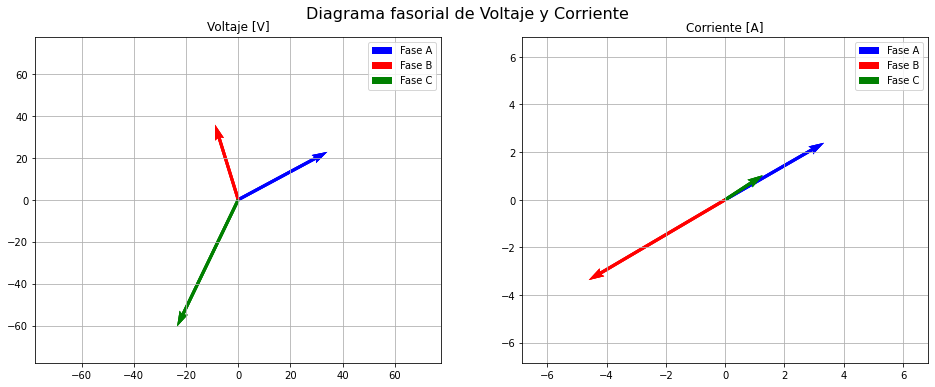

In [11]:
# Creando la figura
fig, ax = plt.subplots(1, 2, figsize =(16, 6))
fig.suptitle('Diagrama fasorial de Voltaje y Corriente', y=0.95, fontsize=16)

lim_axis_V = np.max([np.float(X_V[-1:,0]), np.float(X_V[-1:,1]),np.float(X_V[-1:,2])])
lim_axis_C = np.max([np.float(X_C[-1:,0]), np.float(X_C[-1:,1]),np.float(X_C[-1:,2])])
print(lim_axis_V)
# Creando el punto de origen para los vectores
x_pos = [0, 0,0] 
y_pos = [0, 0,0]

ax[0].quiver(x_pos, y_pos, Xc_V[-1,0], Xs_V[-1,0], angles='xy', scale_units = 'xy', scale=1, color=['b'], label='Fase A')  
ax[0].quiver(x_pos, y_pos, Xc_V[-1,1], Xs_V[-1,1], angles='xy', scale_units = 'xy', scale=1, color=['r'], label='Fase B')  
ax[0].quiver(x_pos, y_pos, Xc_V[-1,2], Xs_V[-1,2], angles='xy', scale_units = 'xy', scale=1, color=['g'], label='Fase C')  
ax[0].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V]) 
ax[0].set_title('Voltaje [V]')
ax[0].legend() #<-- Se nombran las leyendas
ax[0].grid(b=True, which='major') #<-- plot grid lines

ax[1].quiver(x_pos, y_pos, Xc_C[-1,0], Xs_C[-1,0], angles='xy', scale_units = 'xy', scale=1, color=['b'], label='Fase A')  
ax[1].quiver(x_pos, y_pos, Xc_C[-1,1], Xs_C[-1,1], angles='xy', scale_units = 'xy', scale=1, color=['r'], label='Fase B')  
ax[1].quiver(x_pos, y_pos, Xc_C[-1,2], Xs_C[-1,2], angles='xy', scale_units = 'xy', scale=1, color=['g'], label='Fase C')  
ax[1].axis([-1.2*lim_axis_C, 1.2*lim_axis_C, -1.2*lim_axis_C, 1.2*lim_axis_C]) 
ax[1].set_title('Corriente [A]')
ax[1].legend() #<-- Se nombran las leyendas
ax[1].grid(b=True, which='major') #<-- plot grid lines